In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from torch import nn 
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import torch

from tqdm import tqdm

from jupyterthemes import jtplot
jtplot.style("grade3")

# Load Data

In [2]:
raw = pd.read_csv('./age_gender.csv')
raw.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


# Visualization

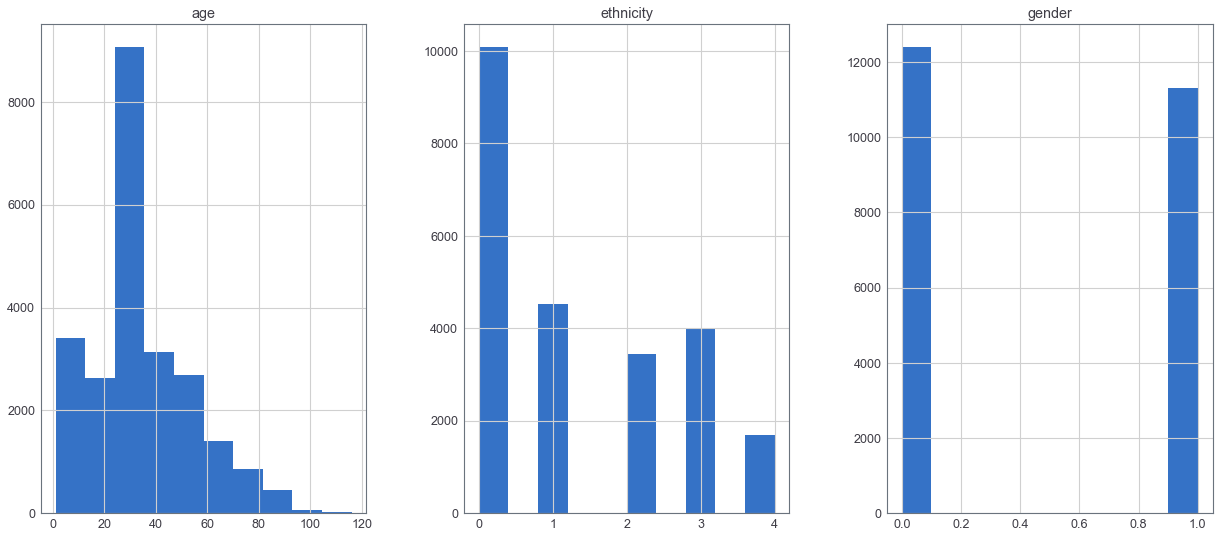

In [3]:
fig, axs = plt.subplots(1,3, figsize=(21,9))
raw.hist('age', ax=axs[0])
raw.hist('ethnicity', ax=axs[1])
raw.hist('gender', ax=axs[2])
plt.show()

# PreProcessing

In [4]:
# convert to images
def str_to_2Dnumpy(x: str):
    return np.array(list(map(int, x.split(' ')))).reshape(48, 48)
raw['pixels'] = raw['pixels'].apply(str_to_2Dnumpy)

In [5]:
# drop the useless column
raw = raw.drop(columns='img_name')
raw.head()

,age,ethnicity,gender,pixels
0,1,2,0,"[[129, 128, 128, 126, 127, 130, 133, 135, 139,..."
1,1,2,0,"[[164, 74, 111, 168, 169, 171, 175, 182, 184, ..."
2,1,2,0,"[[67, 70, 71, 70, 69, 67, 70, 79, 90, 103, 116..."
3,1,2,0,"[[193, 197, 198, 200, 199, 200, 202, 203, 204,..."
4,1,2,0,"[[202, 205, 209, 210, 209, 209, 210, 211, 212,..."


# Test Model Ability

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64*10*10, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))

        return output
    
def normalization(data, mean, std):
    return (data - mean) / std

In [7]:
summary(Model().cuda(), (1,48,48))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 32, 46, 46]          320
|    └─BatchNorm2d: 2-2                  [-1, 32, 46, 46]          64
|    └─ReLU: 2-3                         [-1, 32, 46, 46]          --
|    └─MaxPool2d: 2-4                    [-1, 32, 23, 23]          --
|    └─Conv2d: 2-5                       [-1, 64, 21, 21]          18,496
|    └─ReLU: 2-6                         [-1, 64, 21, 21]          --
|    └─MaxPool2d: 2-7                    [-1, 64, 10, 10]          --
├─Sequential: 1-2                        [-1, 1]                   --
|    └─Linear: 2-8                       [-1, 64]                  409,664
|    └─ReLU: 2-9                         [-1, 64]                  --
|    └─Linear: 2-10                      [-1, 1]                   65
|    └─Sigmoid: 2-11                     [-1, 1]                   --
Total

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 32, 46, 46]          320
|    └─BatchNorm2d: 2-2                  [-1, 32, 46, 46]          64
|    └─ReLU: 2-3                         [-1, 32, 46, 46]          --
|    └─MaxPool2d: 2-4                    [-1, 32, 23, 23]          --
|    └─Conv2d: 2-5                       [-1, 64, 21, 21]          18,496
|    └─ReLU: 2-6                         [-1, 64, 21, 21]          --
|    └─MaxPool2d: 2-7                    [-1, 64, 10, 10]          --
├─Sequential: 1-2                        [-1, 1]                   --
|    └─Linear: 2-8                       [-1, 64]                  409,664
|    └─ReLU: 2-9                         [-1, 64]                  --
|    └─Linear: 2-10                      [-1, 1]                   65
|    └─Sigmoid: 2-11                     [-1, 1]                   --
Total

In [8]:
device = torch.device('cuda')
X_train, X_test, y_train, y_test = train_test_split(np.array(raw['pixels'].values.tolist()).astype(np.float64), raw['gender'].values, test_size=0.3, shuffle=True)

# mean, std = X_train.mean(axis=0), X_train.std(axis=0)
# X_train = normalization(X_train, mean, std)
# X_test = normalization(X_test, mean, std)

In [9]:
train_x, train_y = torch.from_numpy(X_train.reshape(-1,1,48,48)).float(), torch.from_numpy(y_train)
test_x, test_y = torch.from_numpy(X_test.reshape(-1,1,48,48)).float(), torch.from_numpy(y_test)

train_data = TensorDataset(train_x, train_y)
test_data = TensorDataset(test_x, test_y)

train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=32)
test_loader = DataLoader(dataset=test_data, shuffle=True, batch_size=32)

In [10]:
net = Model().to(device)
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.SGD(
    net.parameters(),
    lr = 0.01
)

In [11]:
test_acc_record = []
train_acc_record = []
train_count, test_count = 0, 0
train_acc, test_acc = 0, 0

for epoch in tqdm(range(0,20)):
    net.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        y_hat = net(x)
        loss = loss_function(y_hat.view(-1), y.to(torch.float))
        train_acc += torch.round(y_hat).view(-1).eq(y).cpu().sum().item()
        train_count += len(y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_acc_record.append(train_acc/train_count)
#     print("training accuracy:", np.round(train_acc_record[-1],4)*100,"%")
    train_acc = 0
    train_count = 0
    
    net.eval()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_hat = torch.round(net(x))
        test_acc += y_hat.view(-1).eq(y).cpu().sum().item()
        test_count += len(y)
    test_acc_record.append(test_acc/test_count)
#     print(">> testing accuracy:", np.round(test_acc_record[-1],4)*100,"%")
    test_acc = 0
    test_count = 0

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:43<00:00,  2.16s/it]


# Learning Curve

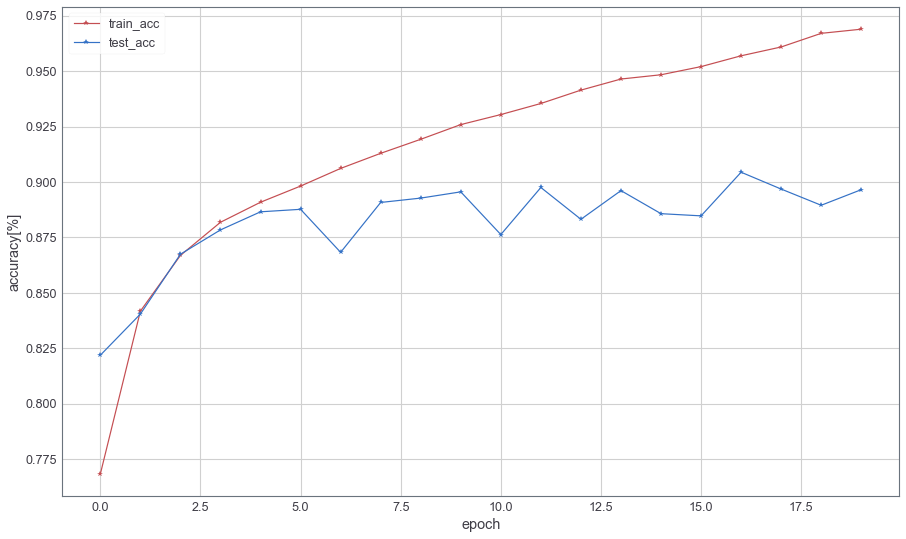

In [12]:
plt.figure(figsize=(15,9))
plt.plot(np.arange(len(train_acc_record)), train_acc_record, 'r-*')
plt.plot(np.arange(len(test_acc_record)), test_acc_record, 'b-*')
plt.legend(['train_acc', 'test_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy[%]')
plt.show()